In [ ]:
import tensorflow as tf

import nobrainer
from nobrainer import dataset, volume

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

dir_path = os.path.abspath("csv/faced_defaced/train_test_fold_1/csv/")
csv_path = os.path.join(dir_path, "training.csv")
# print(dir_path, csv_path)


labels = pd.read_csv(csv_path)["Y"].values
paths = pd.read_csv(csv_path)["X"].values


# print(labels)

n_classes=2
volume_shape = (256, 256, 256)
block_shape = (128, 128, 128)


training_paths = zip(paths, labels)

print(training_paths)

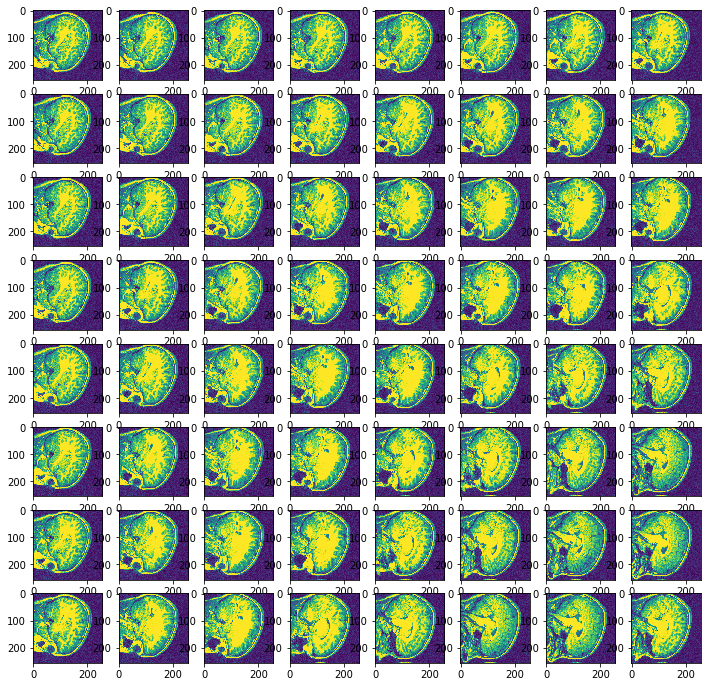

In [38]:
import sys
sys.path.append("..")

from sklearn import preprocessing

import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import binascii
from helpers.utils import load_vol, save_vol
from preprocessing.normalization import standardize_volume, normalize_volume
from preprocessing.conform import conform_data
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess

orig_data_face = "/work/01329/poldrack/data/mriqc-net/data/face/T1w"

in_file = '/work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-69_T1w.nii.gz'

def clip(x, q=90):
    
    min_val = 0
    max_val = np.percentile(
        x, q,
        axis=None
    )
    
    x = np.clip(
        x,
        a_min=min_val,
        a_max=max_val
    )
    
    return x

def standardize(x):
    
    std = np.std(x)
    median = np.percentile(x, q=50,axis=None)
    return (x - median) / std

def normalize(x):
    min_vol = np.min(x)
    max_vol = np.max(x)
    
    return (x - min_vol) / (max_vol - min_vol + 1e-3)
    
%matplotlib inline
    
f, axarr = plt.subplots(8, 8, figsize=(12, 12))

if isinstance(in_file, (str, Path)):
    in_file = nb.load(in_file)
    out = clip(np.array(in_file.dataobj))
    out = normalize(out)
    out = standardize(out)
    
    for i in range(1, 9):
        for j in range(1, 9):
#             plt.plot(out[i*j, :, :])
            axarr[i-1, j-1].imshow(out[i*j + 64, :, :])
    
# plt.show()
#     print(in_file)

In [2]:
import os, sys

sys.path.append("..")
import binascii
from helpers.utils import load_vol, save_vol
from preprocessing.normalization import standardize_volume, normalize_volume
from preprocessing.conform import conform_data
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess


orig_data_face = "/work/01329/poldrack/data/mriqc-net/data/face/T1w"
orig_data_deface = "/work/01329/poldrack/data/mriqc-net/data/defaced"

save_data_face = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face"
save_data_deface = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface"

os.makedirs(save_data_face, exist_ok=True)
os.makedirs(save_data_deface, exist_ok=True)


conform_size = (64, 64, 64)


def is_gz_file(filepath):
    if os.path.splitext(filepath)[1] == ".gz":
        with open(filepath, "rb") as test_f:
            return binascii.hexlify(test_f.read(2)) == b"1f8b"
    return False


def preprocess(pth, conform_size, save_data_path):
    """
    """
    filename = pth.split("/")[-1]
#     print("Confirmation step")
    conform_data(
        pth,
        out_size=conform_size,
        out_file=os.path.join(save_data_path, filename),
        out_zooms=(4.0, 4.0, 4.0)
    )

#     print("Normalize/Standardize step")
#     volume = normalize_volume(standardize_volume(volume))
#     save_path = os.path.join(save_data_path, filename)

#     newaffine = np.eye(4)
#     newaffine[:3, 3] = -0.5 * (np.array(conform_size) - 1)
#     nii = nb.Nifti1Image(volume, newaffine, None)

#     print("Save new affine")
#     nii.to_filename(save_path)
#     return save_path


def checkNonConformed(orig_path, save_path):

    conform = []
    orig = []

    for path in glob(save_path + "/*/*.nii*"):
        tempname = path.split("/")[-1]
        ds = path.split("/")[-2]
        conform.append(ds + "/" + tempname)

    print("Total Conformed: ", len(conform))

    for path in glob(orig_path + "/*/*.nii*"):
        tempname = path.split("/")[-1]
        ds = path.split("/")[-2]
        orig.append(ds + "/" + tempname)

    print("Total Original: ", len(orig))

    print("Total not conformed: ", len(orig) - len(conform))

    count = 0
    for f in orig:
        exists = False
        for fc in conform:
            if fc in f:
                exists = True
        if not exists:
            count += 1
            print("Not conformed file: ", f)


for path in glob(orig_data_face + "/*/*.nii*"):
    try:
        print("Orig Path: ", path)
        if not is_gz_file(path) and os.path.splitext(path)[1] == ".gz":
            tempname = path.split("/")[-1]
            ds = path.split("/")[-2]
            rename_file = os.path.splitext(tempname)[0]
            dst = os.path.join(save_data_face, rename_file)
            print(dst)
            subprocess.call(["cp", path, dst])
            ds_save_path = os.path.join(save_data_face, ds)
            if not os.path.exists(ds_save_path):
                os.makedirs(ds_save_path)
            print(preprocess(dst, conform_size, save_data_path=ds_save_path))
        else:
            ds = path.split("/")[-2]
            ds_save_path = os.path.join(save_data_face, ds)
            if not os.path.exists(ds_save_path):
                os.makedirs(ds_save_path)
            print(preprocess(path, conform_size, save_data_path=ds_save_path))
    except:
        print("Preprocessing incomplete. Exception occurred.")
        pass


for path in glob(orig_data_deface + "/*/*.nii*"):
    try:
        print("Orig Path: ", path)
        if not is_gz_file(path) and os.path.splitext(path)[1] == ".gz":
            tempname = path.split("/")[-1]
            ds = path.split("/")[-2]
            rename_file = os.path.splitext(tempname)[0]
            dst = os.path.join(save_data_deface, rename_file)
#             print(dst)
            subprocess.call(["cp", path, dst])
            ds_save_path = os.path.join(save_data_deface, ds)
            if not os.path.exists(ds_save_path):
                os.makedirs(ds_save_path)
            preprocess(dst, conform_size, save_data_path=ds_save_path))
        else:
            ds = path.split("/")[-2]
            ds_save_path = os.path.join(save_data_deface, ds)
            if not os.path.exists(ds_save_path):
                os.makedirs(ds_save_path)
            preprocess(path, conform_size, save_data_path=ds_save_path)
    except:
        print("Preprocessing incomplete. Exception occurred.")
        pass
    

checkNonConformed(orig_data_face, save_data_face)
checkNonConformed(orig_data_deface, save_data_deface)




Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000140_anat/sub-10_T1w.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/sub-10_T1w.nii
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000140_anat/sub-07_T1w.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/sub-07_T1w.nii
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000140_anat/sub-19_T1w.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/sub-19_T1w.nii
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000140_anat/sub-08_T1w.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/sub-08_T1w.nii
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000140_anat/sub-13_T1w.nii.gz
/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/sub-13_T1w.nii
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-n

../preprocessing/conform.py:47: RuntimeWarning: invalid value encountered in less
  resampled[resampled < 0] = 0


None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-07_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-19_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-08_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-13_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-22_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-26_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-20_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds001985_anat/sub-04_T1w.nii.gz
Confirmation step
None
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/defaced/ds0019

In [ ]:
import nibabel as nb

in_file = '/work/06850/sbansal6/maverick2/mriqc-shared/deface/ds001912_anat/sub-01_ses-01_run-01_T1w.nii.gz'
# dst_path = '/work/06850/sbansal6/maverick2/mriqc-shared/deface'

# print(is_gz_file(in_file))

# if not is_gz_file(in_file):
#     filename = in_file.split("/")[-1]
#     print(filename)
#     rename_file = os.path.splitext(filename)[0]
#     dst = os.path.join(dst_path, rename_file)
    
#     subprocess.call(['cp', in_file, dst])
    
    
# if isinstance(in_file, (str, Path)):
i_file = nb.load(in_file)
print(i_file)



In [ ]:
face_C = []
face_O = []

for path in glob(save_data_face + "/*/*.nii*"):
    tempname = path.split("/")[-1]
    ds = path.split("/")[-2]
    face_C.append(ds + '/' + tempname)

print(len(face_C))
# print(face_C)


for path in glob(orig_data_face + "/*/*.nii*"):
    tempname = path.split("/")[-1]
    ds = path.split("/")[-2]
    face_O.append(ds + '/' + tempname)

print(len(face_O))
# print(face_O)

count = 0
for f in face_O:
    exists = False
    for fc in face_C:
        if fc in f:
            exists = True
    if not exists:
        count += 1
        print(f)
print(count)

In [3]:
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd

face_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face"
deface_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface"

paths = []
labels = []

for path in glob(deface_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(0)

for path in glob(face_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(1)
    
print(len(paths))
print(len(labels))

save_path = "/work/06850/sbansal6/maverick2/mriqc-shared/csv"

os.makedirs(save_path, exist_ok=True)

df = pd.DataFrame()
df["X"] = paths
df["Y"] = labels
df.to_csv(os.path.join(save_path, "all.csv"))

SPLITS = 10
skf = StratifiedKFold(n_splits=SPLITS)
fold_no = 1

for train_index, test_index in skf.split(paths, labels):
    out_path = save_path + "/train_test_fold_{}/csv/".format(fold_no)

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    image_train, image_test = (
        itemgetter(*train_index)(paths),
        itemgetter(*test_index)(paths),
    )
    label_train, label_test = (
        itemgetter(*train_index)(labels),
        itemgetter(*test_index)(labels),
    )

    # image_train = [os.path.join(data_path, 'sub-' + str(pth) + '_T1w.nii.gz') for pth in image_train]
    train_data = {"X": image_train, "Y": label_train}
    df_train = pd.DataFrame(train_data)
    df_train.to_csv(os.path.join(out_path, "training.csv"), index=False)

    # image_test = [os.path.join(data_path, 'sub-' + str(pth) + '_T1w.nii.gz') for pth in image_test]
    validation_data = {"X": image_test, "Y": label_test}
    df_validation = pd.DataFrame(validation_data)
    df_validation.to_csv(os.path.join(out_path, "validation.csv"), index=False)

    fold_no += 1

1654
1654


In [3]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd

SPLITS = 10

for fold in range(1, SPLITS+1):
    
    dir_path = "/work/06850/sbansal6/maverick2/mriqc-shared/csv/train_test_fold_{}/csv/".format(fold)
    
    tf_records_dir = "/work/06850/sbansal6/maverick2/mriqc-shared/tfrecords/tfrecords_fold_{}/".format(fold)
    os.makedirs(tf_records_dir, exist_ok=True)
    
    train_csv_path = os.path.join(dir_path, "training.csv")
    valid_csv_path = os.path.join(dir_path, "validation.csv")
    
    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    train_D = list(zip(train_paths, train_labels))
    random.shuffle(train_D)
#     print(train_D[0])
    
    valid_paths = pd.read_csv(valid_csv_path)["X"].values
    valid_labels = pd.read_csv(valid_csv_path)["Y"].values
    valid_D = list(zip(valid_paths, valid_labels))
    random.shuffle(valid_D)
    
    train_write_path = os.path.join(tf_records_dir, 'data-train_shard-{shard:03d}.tfrec')
    valid_write_path = os.path.join(tf_records_dir, 'data-valid_shard-{shard:03d}.tfrec')
    
    nobrainer.tfrecord.write(
        features_labels=train_D,
        filename_template=train_write_path,
        examples_per_shard=3)
    
    nobrainer.tfrecord.write(
        features_labels=valid_D,
        filename_template=valid_write_path,
        examples_per_shard=1)

165/165 [==============================] - 20s 120ms/step


In [16]:
print(tf.__version__)

2.1.0


In [35]:
import nobrainer
from nobrainer.io import _is_gzipped
from nobrainer.volume import to_blocks

import tensorflow as tf
import glob
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/'

# function to apply augmentations to tf dataset
def apply_augmentations(features, labels):

    """ Apply <TYPE_OF> augmentation to the dataset
    
    """
    #     iaa.SomeOf(
    #             (0, 3),
    #             [
    #                 iaa.Fliplr(0.5),
    #                 iaa.Flipud(0.5),
    #                 iaa.Noop(),
    #                 iaa.OneOf(
    #                     [
    #                         iaa.Affine(rotate=90),
    #                         iaa.Affine(rotate=180),
    #                         iaa.Affine(rotate=270),
    #                     ]
    #                 ),
    #                 # iaa.GaussianBlur(sigma=(0.0, 0.2)),
    #             ],
    #         )

    return


# from nobrainer.dataset
def tfrecord_dataset(
    file_pattern,
    volume_shape,
    shuffle,
    scalar_label,
    compressed=True,
    num_parallel_calls=None,
):
    """Return `tf.data.Dataset` from TFRecord files."""

    dataset = tf.data.Dataset.list_files(file_pattern, shuffle=shuffle)
    # Read each of these files as a TFRecordDataset.
    # Assume all files have same compression type as the first file.
    compression_type = "GZIP" if compressed else None
    cycle_length = 1 if num_parallel_calls is None else num_parallel_calls
    dataset = dataset.interleave(
        map_func=lambda x: tf.data.TFRecordDataset(
            x, compression_type=compression_type
        ),
        cycle_length=cycle_length,
        num_parallel_calls=num_parallel_calls,
    )
    parse_fn = parse_example_fn(volume_shape=volume_shape, scalar_label=scalar_label)
    dataset = dataset.map(map_func=parse_fn, num_parallel_calls=num_parallel_calls)
    return dataset


# from nobrainer.tfrecord
def parse_example_fn(volume_shape, scalar_label=False):
    """Return function that can be used to read TFRecord file into tensors.
    Parameters
    ----------
    volume_shape: sequence, the shape of the feature data. If `scalar_label` is `False`,
        this also corresponds to the shape of the label data.
    scalar_label: boolean, if `True`, label is a scalar. If `False`, label must be the
        same shape as feature data.
    Returns
    -------
    Function with which a TFRecord file can be parsed.
    """

    @tf.function
    def parse_example(serialized):
        """Parse one example from a TFRecord file made with Nobrainer.
        Parameters
        ----------
        serialized: str, serialized proto message.
        Returns
        -------
        Tuple of two tensors. If `scalar_label` is `False`, both tensors have shape
        `volume_shape`. Otherwise, the first tensor has shape `volume_shape`, and the
        second is a scalar tensor.
        """
        features = {
            "feature/shape": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
            "feature/value": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
            "label/value": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
            "label/rank": tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
        }
        e = tf.io.parse_single_example(serialized=serialized, features=features)
        x = tf.io.decode_raw(e["feature/value"], _TFRECORDS_DTYPE)
        y = tf.io.decode_raw(e["label/value"], _TFRECORDS_DTYPE)
        # TODO: this line does not work. The shape cannot be determined
        # dynamically... for now.
        # xshape = tf.cast(
        #     tf.io.decode_raw(e["feature/shape"], _TFRECORDS_DTYPE), tf.int32)
        x = tf.reshape(x, shape=volume_shape)
        if not scalar_label:
            y = tf.reshape(y, shape=volume_shape)
        else:
            y = tf.reshape(y, shape=[1])
        return x, y

    return parse_example


def standardize(x, clip_value_min=-5000, clip_value_max=5000):
    """Standard score input tensor.
    Implements `(x - mean(x)) / stdev(x)`.
    Parameters
    ----------
    x: tensor, values to standardize.
    Returns
    -------
    Tensor of standardized values. Output has mean 0 and standard deviation 1.
    """
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.where(tf.math.is_inf(x), tf.zeros_like(x), x)
    x = tf.convert_to_tensor(x)
    if x.dtype != tf.float32:
        x = tf.cast(x, tf.float32)
    # x = tf.clip_by_value(
    #     x, 
    #    clip_value_min, 
    #    clip_value_max, name=None
    #    )
    
    mean, var = tf.nn.moments(x, axes=None)
    std = tf.sqrt(var)
    return (x - mean) / std


def normalize(x):
    """Standard score input tensor.
    Implements `(x - mean(x)) / stdev(x)`.
    Parameters
    ----------
    x: tensor, values to standardize.
    Returns
    -------
    Tensor of standardized values. Output has mean 0 and standard deviation 1.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != tf.float32:
        x = tf.cast(x, tf.float32)

    max_value = tf.math.reduce_max(
                x, 
                axis=None, 
                keepdims=False, name=None
                )

    min_value = tf.math.reduce_min(
                x, 
                axis=None, 
                keepdims=False, name=None
                )
    return (x - min_value) / (max_value - min_value + 1e-3)

def get_dataset(
    file_pattern,
    n_classes,
    batch_size,
    volume_shape,
    plane,
    n = 4,
    block_shape=None,
    n_epochs=None,
    mapping=None,
    augment=False,
    shuffle_buffer_size=None,
    num_parallel_calls=AUTOTUNE,
):

    """ Returns tf.data.Dataset after preprocessing from 
    tfrecords for training and validation
    
    Parameters
    ----------
    file_pattern:
    
    n_classes:
    
    """

    files = glob.glob(file_pattern)

    if not files:
        raise ValueError("no files found for pattern '{}'".format(file_pattern))

    compressed = _is_gzipped(files[0])
    shuffle = bool(shuffle_buffer_size)

    ds = nobrainer.dataset.tfrecord_dataset(
        file_pattern=file_pattern,
        volume_shape=volume_shape,
        shuffle=shuffle,
        scalar_label=True,
        compressed=compressed,
        num_parallel_calls=num_parallel_calls,
    )

    if augment:
        ds = ds.map(
            lambda x, y: tf.cond(
                tf.random.uniform((1,)) > 0.5,
                true_fn=lambda: apply_augmentations(x, y),
                false_fn=lambda: (x, y),
            ),
            num_parallel_calls=num_parallel_calls,
        )

    def _ss(x, y):
        x, y = structural_slice(x, y, plane, n)
        return (x, y)

    ds = ds.map(_ss, num_parallel_calls)

    #     def _f(x, y):
    #         x = to_blocks(x, block_shape)
    #         n_blocks = x.shape[0]
    #         y = tf.repeat(y, n_blocks)
    #         return (x, y)
    #     ds = ds.map(_f, num_parallel_calls=num_parallel_calls)

    # This step is necessary because it reduces the extra dimension.
    # ds = ds.unbatch()

    # add a single dimension at the end
    # ds = ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

    ds = ds.prefetch(buffer_size=batch_size)
    
    if batch_size is not None:
        ds = ds.batch(batch_size=batch_size, drop_remainder=True)
        ds = ds.map(lambda x,y: (tf.reshape
                                 (x,
                                  ((3, batch_size*n,)
                                   if plane == "combined"
                                   else (batch_size*n,)
                                  ) + volume_shape[:2] +(1,)), 
                                 tf.reshape(y, (batch_size*n,))))

    if shuffle_buffer_size:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat the dataset n_epochs times
#     ds = ds.repeat(n_epochs)

    return ds


def structural_slice(x, y, plane, n=4):

    """ Transpose dataset based on the plane
    
    Parameters
    ----------
    x:
    
    y:
    
    plane:
    
    """

    options = ["axial", "coronal", "sagittal", "combined"]
    shape = np.array(x.shape)
    x = normalize(standardize(x))
    
#     print(tf.math.reduce_max(
#                 x,
#                 axis=None,
#                 keepdims=False, name=None
#                 ), 
#           tf.math.reduce_min(
#                 x,
#                 axis=None,
#                 keepdims=False, name=None
#                 )
#          )
    
    
    if isinstance(plane, str) and plane in options:
        if plane == "axial":
            idx = np.random.randint(2*shape[0]//5, 3*shape[0]//5, n)
            x = x

        if plane == "coronal":
            idx = np.random.randint(2*shape[1]//4, 3*shape[1]//4, n)
            x = tf.transpose(x, perm=[1, 2, 0])

        if plane == "sagittal":
            idx = np.random.randint(shape[2]//3, 2*shape[2]//3, n)
            x = tf.transpose(x, perm=[2, 0, 1])

        if plane == "combined":
            temp = []
            for op in options[:-1]:
                temp.append(tf.expand_dims(structural_slice(x, y, op, n)[0], axis=1))
            x = tf.concat(temp, axis = 1)

        if not plane == "combined":
            x = tf.squeeze(tf.gather_nd(x, idx.reshape(n, 1, 1)), axis=1)
        
#         print(x)
        
        x = tf.convert_to_tensor(x)
        y = tf.repeat(y, n)
        
        return x, y
    else:
        raise ValueError("expected plane to be one of ['axial', 'coronal', 'sagittal']")



if __name__ == "__main__":

    n_classes = 2
    global_batch_size = 8
    volume_shape = (64, 64, 64)
    ds = get_dataset(
        ROOTDIR + "tfrecords_no_ds001985/tfrecords_fold_1/data-train_*",
        n_classes=n_classes,
        batch_size=global_batch_size,
        volume_shape=volume_shape,
        plane="combined",
        shuffle_buffer_size=10,
    )
    
    print(ds)
    
    temp = len(list(ds.as_numpy_iterator()))
    
    
#     for _ in range(100):
#         x,y=next(ds.as_numpy_iterator())
#         print (np.min(x), np.max(x), np.unique(y))
#         if np.max(x) == np.nan:
#             print(x)
            
        
#     print (y)
#     import matplotlib 
#     matplotlib.use('Agg')
#     import matplotlib.pyplot as plt

#     rows = 5
#     count = 1
#     idx = np.random.randint(0, 32, rows)
#     for i in range(rows):
#         for j in range(3):
#             plt.subplot(rows, 3, count)
#             plt.imshow(x[idx[i], j, :, :, 0])
#             plt.title(str(y[idx[i]]))
#             count += 1
#     plt.savefig("processed_image.png")
    
# dataset_train_coronal = get_dataset("tfrecords/tfrecords_fold_1/data-train_*",
#                             n_classes=n_classes,
#                             batch_size=global_batch_size,
#                             volume_shape=volume_shape,
#                             block_shape=block_shape,
#                             plane='coronal',
#                             shuffle_buffer_size=3)

# dataset_train_sagittal = get_dataset("tfrecords/tfrecords_fold_1/data-train_*",
#                             n_classes=n_classes,
#                             batch_size=global_batch_size,
#                             volume_shape=volume_shape,
#                             block_shape=block_shape,
#                             plane='sagittal',
#                             shuffle_buffer_size=3)


<ShuffleDataset shapes: ((3, 32, 64, 64, 1), (32,)), types: (tf.float32, tf.float32)>
182


In [ ]:
print(dataset_train_axial)
print(dataset_train_coronal)
print(dataset_train_sagittal)

In [37]:
import glob 

def get_steps_per_epoch(n_volumes, volume_shape, block_shape, batch_size):
    def get_n(a, k):
        return (a - k) / k + 1

    n_blocks = tuple(get_n(aa, kk) for aa, kk in zip(volume_shape, block_shape))

    for n in n_blocks:
        if not n.is_integer() or n < 1:
            raise ValueError(
                "cannot create non-overlapping blocks with the given parameters."
            )
    n_blocks_per_volume = np.prod(n_blocks).astype(int)

    steps = n_blocks_per_volume * n_volumes / batch_size
    steps = math.ceil(steps)
    return steps

n_volumes / batch_size


In [24]:
# Std packages
import sys, os
import glob
import math

sys.path.append("..")

# Custom packages
from models import modelN

# Tf packages
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
import nobrainer
from tensorflow.keras import metrics
from tensorflow.keras import losses

ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/'

def train(
    volume_shape=(64, 64, 64),
    image_size=(64, 64),
    dropout=0.4,
    batch_size=4,
    n_classes=2,
    n_epochs=30,
):

    tpaths = glob.glob(ROOTDIR+"tfrecords_no_ds001985/tfrecords_fold_1/data-train_*")
    vpaths = glob.glob(ROOTDIR+"tfrecords_no_ds001985/tfrecords_fold_1/data-valid_*")
    
    print("Total Training data: ", len(tpaths))
    print("Total Validation data: ", len(vpaths))

    planes = ["axial", "coronal", "sagittal", "combined"]

#     strategy = tf.distribute.MirroredStrategy()
#     BATCH_SIZE_PER_REPLICA = batch_size
#     global_batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    
    global_batch_size = batch_size

    model_save_path = "./model_save_dir"

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    cp_save_path = os.path.join(model_save_path, "weights")

    logdir_path = os.path.join(model_save_path, "tb_logs")
    if not os.path.exists(logdir_path):
        os.makedirs(logdir_path)


    for plane in planes:

        logdir = os.path.join(logdir_path, plane)
        os.makedirs(logdir, exist_ok=True)

        tbCallback = TensorBoard(
            log_dir=logdir, histogram_freq=0, write_graph=True, write_images=False,
        )

        os.makedirs(os.path.join(cp_save_path, plane), exist_ok=True)

        model_checkpoint = ModelCheckpoint(
            os.path.join(cp_save_path, plane, "best-wts.h5"),
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            mode="min",
        )

#         with strategy.scope():

        if not plane == "combined": 
            lr = 1e-4
            model = modelN.Submodel(
                input_shape=image_size,
                dropout=dropout,
                name=plane,
                include_top=True,
                weights=None,
            )
        else:
            lr = 5e-5
            model = modelN.CombinedClassifier(
                input_shape=image_size, 
                dropout=dropout, 
                wts_root=cp_save_path
            )



        print("Submodel: ", plane)
        print(model.summary())

        METRICS = [
            metrics.TruePositives(name="tp"),
            metrics.FalsePositives(name="fp"),
            metrics.TrueNegatives(name="tn"),
            metrics.FalseNegatives(name="fn"),
            metrics.BinaryAccuracy(name="accuracy"),
            #metrics.Precision(name="precision"),
            #metrics.Recall(name="recall"),
            #metrics.AUC(name="auc"),
        ]

        model.compile(
            loss=tf.keras.losses.binary_crossentropy,
            optimizer="adam",
            metrics=METRICS,
        )

        print("GLOBAL BATCH SIZE: ", global_batch_size)
        
        
        dataset_train = get_dataset(
            ROOTDIR + "tfrecords_no_ds001985/tfrecords_fold_1/data-train_*",
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            shuffle_buffer_size=global_batch_size,
        )
        
        print(dataset_train)
        
        dataset_valid = get_dataset(
            ROOTDIR + "tfrecords_no_ds001985/tfrecords_fold_1/data-valid_*",
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            shuffle_buffer_size=global_batch_size,
        )
        
        print(dataset_valid)
        
        steps_per_epoch = math.ceil(len(tpaths) / batch_size)
        
        validation_steps = math.ceil(len(vpaths) / batch_size)

        print(steps_per_epoch, validation_steps)

        model.fit(
            dataset_train,
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=dataset_valid,
            validation_steps=validation_steps,
            callbacks=[tbCallback, model_checkpoint],
        )

        del model
        K.clear_session()
    


if __name__ == "__main__":
    train()


Total Training data:  488
Total Validation data:  167
Submodel:  axial
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
axial (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 8)         80        
_________________________________________________________________
batch_normalization_36 (Batc (None, 64, 64, 8)         32        
_________________________________________________________________
activation_36 (Activation)   (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
batch_normalization_37 (Batc (None, 64, 64, 8)         32        
______________________________________________________

ValueError: in converted code:

    /home1/06850/sbansal6/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home1/06850/sbansal6/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /home1/06850/sbansal6/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:539 standardize_input_data
        str(data)[:200] + '...')

    ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), for inputs ['axial', 'coronal', 'sagittal'] but instead got the following list of 1 arrays: [<tf.Tensor 'args_0:0' shape=(3, 16, 64, 64, 1) dtype=float32>]...


In [5]:
!pip install tensorflow-gpu==2.1

In [4]:
tf.__version__

'2.1.0'

In [ ]:
import nobrainer
from nobrainer.io import _is_gzipped
from nobrainer.volume import to_blocks

import tensorflow as tf
import glob
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/'

# function to apply augmentations to tf dataset
def apply_augmentations(features, labels):

    """ Apply <TYPE_OF> augmentation to the dataset
    
    """
    #     iaa.SomeOf(
    #             (0, 3),
    #             [
    #                 iaa.Fliplr(0.5),
    #                 iaa.Flipud(0.5),
    #                 iaa.Noop(),
    #                 iaa.OneOf(
    #                     [
    #                         iaa.Affine(rotate=90),
    #                         iaa.Affine(rotate=180),
    #                         iaa.Affine(rotate=270),
    #                     ]
    #                 ),
    #                 # iaa.GaussianBlur(sigma=(0.0, 0.2)),
    #             ],
    #         )

    return


# from nobrainer.dataset
def tfrecord_dataset(
    file_pattern,
    volume_shape,
    shuffle,
    scalar_label,
    compressed=True,
    num_parallel_calls=None,
):
    """Return `tf.data.Dataset` from TFRecord files."""

    dataset = tf.data.Dataset.list_files(file_pattern, shuffle=shuffle)
    # Read each of these files as a TFRecordDataset.
    # Assume all files have same compression type as the first file.
    compression_type = "GZIP" if compressed else None
    cycle_length = 1 if num_parallel_calls is None else num_parallel_calls
    dataset = dataset.interleave(
        map_func=lambda x: tf.data.TFRecordDataset(
            x, compression_type=compression_type
        ),
        cycle_length=cycle_length,
        num_parallel_calls=num_parallel_calls,
    )
    parse_fn = parse_example_fn(volume_shape=volume_shape, scalar_label=scalar_label)
    dataset = dataset.map(map_func=parse_fn, num_parallel_calls=num_parallel_calls)
    return dataset


# from nobrainer.tfrecord
def parse_example_fn(volume_shape, scalar_label=False):
    """Return function that can be used to read TFRecord file into tensors.
    Parameters
    ----------
    volume_shape: sequence, the shape of the feature data. If `scalar_label` is `False`,
        this also corresponds to the shape of the label data.
    scalar_label: boolean, if `True`, label is a scalar. If `False`, label must be the
        same shape as feature data.
    Returns
    -------
    Function with which a TFRecord file can be parsed.
    """

    @tf.function
    def parse_example(serialized):
        """Parse one example from a TFRecord file made with Nobrainer.
        Parameters
        ----------
        serialized: str, serialized proto message.
        Returns
        -------
        Tuple of two tensors. If `scalar_label` is `False`, both tensors have shape
        `volume_shape`. Otherwise, the first tensor has shape `volume_shape`, and the
        second is a scalar tensor.
        """
        features = {
            "feature/shape": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
            "feature/value": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
            "label/value": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
            "label/rank": tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
        }
        e = tf.io.parse_single_example(serialized=serialized, features=features)
        x = tf.io.decode_raw(e["feature/value"], _TFRECORDS_DTYPE)
        y = tf.io.decode_raw(e["label/value"], _TFRECORDS_DTYPE)
        # TODO: this line does not work. The shape cannot be determined
        # dynamically... for now.
        # xshape = tf.cast(
        #     tf.io.decode_raw(e["feature/shape"], _TFRECORDS_DTYPE), tf.int32)
        x = tf.reshape(x, shape=volume_shape)
        if not scalar_label:
            y = tf.reshape(y, shape=volume_shape)
        else:
            y = tf.reshape(y, shape=[1])
        return x, y

    return parse_example


def standardize(x, clip_value_min=-5000, clip_value_max=5000):
    """Standard score input tensor.
    Implements `(x - mean(x)) / stdev(x)`.
    Parameters
    ----------
    x: tensor, values to standardize.
    Returns
    -------
    Tensor of standardized values. Output has mean 0 and standard deviation 1.
    """
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.where(tf.math.is_inf(x), tf.zeros_like(x), x)
    x = tf.convert_to_tensor(x)
    if x.dtype != tf.float32:
        x = tf.cast(x, tf.float32)
    # x = tf.clip_by_value(
    #     x, 
    #    clip_value_min, 
    #    clip_value_max, name=None
    #    )
    
    mean, var = tf.nn.moments(x, axes=None)
    std = tf.sqrt(var)
    return (x - mean) / std


def normalize(x):
    """Standard score input tensor.
    Implements `(x - mean(x)) / stdev(x)`.
    Parameters
    ----------
    x: tensor, values to standardize.
    Returns
    -------
    Tensor of standardized values. Output has mean 0 and standard deviation 1.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != tf.float32:
        x = tf.cast(x, tf.float32)

    max_value = tf.math.reduce_max(
                x, 
                axis=None, 
                keepdims=False, name=None
                )

    min_value = tf.math.reduce_min(
                x, 
                axis=None, 
                keepdims=False, name=None
                )
    return (x - min_value) / (max_value - min_value + 1e-3)

def get_dataset(
    file_pattern,
    n_classes,
    batch_size,
    volume_shape,
    plane,
    n = 4,
    block_shape=None,
    n_epochs=None,
    mapping=None,
    augment=False,
    shuffle_buffer_size=None,
    num_parallel_calls=AUTOTUNE,
):

    """ Returns tf.data.Dataset after preprocessing from 
    tfrecords for training and validation
    
    Parameters
    ----------
    file_pattern:
    
    n_classes:
    
    """

    files = glob.glob(file_pattern)

    if not files:
        raise ValueError("no files found for pattern '{}'".format(file_pattern))

    compressed = _is_gzipped(files[0])
    shuffle = bool(shuffle_buffer_size)

    ds = nobrainer.dataset.tfrecord_dataset(
        file_pattern=file_pattern,
        volume_shape=volume_shape,
        shuffle=shuffle,
        scalar_label=True,
        compressed=compressed,
        num_parallel_calls=num_parallel_calls,
    )

    if augment:
        ds = ds.map(
            lambda x, y: tf.cond(
                tf.random.uniform((1,)) > 0.5,
                true_fn=lambda: apply_augmentations(x, y),
                false_fn=lambda: (x, y),
            ),
            num_parallel_calls=num_parallel_calls,
        )

    def _ss(x, y):
        x, y = structural_slice(x, y, plane, n)
        return (x, y)

    ds = ds.map(_ss, num_parallel_calls)

    #     def _f(x, y):
    #         x = to_blocks(x, block_shape)
    #         n_blocks = x.shape[0]
    #         y = tf.repeat(y, n_blocks)
    #         return (x, y)
    #     ds = ds.map(_f, num_parallel_calls=num_parallel_calls)

    # This step is necessary because it reduces the extra dimension.
    # ds = ds.unbatch()

    # add a single dimension at the end
    # ds = ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

    ds = ds.prefetch(buffer_size=batch_size)
    def reshape(x,y):
        if plane == "combined":
            for _ in 3:
                pass
        return (x, y)
    if batch_size is not None:
        ds = ds.batch(batch_size=batch_size, drop_remainder=True)
        # ds = ds.map(lambda x,y: (tf.reshape(x, ((3, batch_size*n,) if plane == "combined" else (batch_size*n,)) + volume_shape[:2] +(1,)), 
        #                         tf.reshape(y, (batch_size*n,))))

    if shuffle_buffer_size:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat the dataset n_epochs times
    ds = ds.repeat(n_epochs)

    return ds


def structural_slice(x, y, plane, n=4):

    """ Transpose dataset based on the plane
    
    Parameters
    ----------
    x:
    
    y:
    
    plane:
    
    """

    options = ["axial", "coronal", "sagittal", "combined"]
    shape = np.array(x.shape)
    x = normalize(standardize(x))
    
    if isinstance(plane, str) and plane in options:
        if plane == "axial":
            idx = np.random.randint(2*shape[0]//5, 3*shape[0]//5)
            x = x

        if plane == "coronal":
            idx = np.random.randint(2*shape[1]//4, 3*shape[1]//4)
            x = tf.transpose(x, perm=[1, 2, 0])

        if plane == "sagittal":
            idx = np.random.randint(shape[2]//3, 2*shape[2]//3)
            x = tf.transpose(x, perm=[2, 0, 1])

        if plane == "combined":
            temp = {}
            for op in options[:-1]:
                temp[op] = structural_slice(x, y, op, n)[0]
            x = temp

        if not plane == "combined": 
            # x = tf.squeeze(tf.gather_nd(x, idx.reshape(n, 1, 1)), axis=1)
            x = tf.convert_to_tensor(tf.expand_dims(x[idx], axis=-1))
        # y = tf.repeat(y, n)
        
        return x, y
    else:
        raise ValueError("expected plane to be one of ['axial', 'coronal', 'sagittal']")



if __name__ == "__main__":

    n_classes = 2
    global_batch_size = 8
    volume_shape = (64, 64, 64)
    ds = get_dataset(
        ROOTDIR + "tfrecords_no_ds001985/tfrecords_fold_1/data-train_*",
        n_classes=n_classes,
        batch_size=global_batch_size,
        volume_shape=volume_shape,
        plane="axial",
        shuffle_buffer_size=3,
    )

    print(ds)
#     for _ in range(100):
#         x,y=next(ds.as_numpy_iterator())
#         print (np.min(x), np.max(x), np.unique(y))
#         if np.max(x) == np.nan:
#             print(x)
#     print (y)
    import matplotlib 
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    
    for _ in range(100):
        x,y=next(ds.as_numpy_iterator())
        rows = 5
        count = 1
        plt.clf()
        idx = np.random.randint(0, 8, rows)
        for i in range(rows):
            for j in range(3):
                plt.subplot(rows, 3, count)
                plt.imshow(x[idx[i], :, :, 0])
                plt.title(str(y[idx[i]]))
                count += 1
            plt.show()
            plt.savefig("processed_image_{}_{}.png".format(i,j))


<RepeatDataset shapes: ((8, 64, 64, 1), (8, 1)), types: (tf.float32, tf.float32)>


/work/06595/kavinash/maverick2/anaconda3/envs/tf37/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/work/06595/kavinash/maverick2/anaconda3/envs/tf37/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/work/06595/kavinash/maverick2/anaconda3/envs/tf37/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/work/06595/kavinash/maverick2/anaconda3/envs/tf37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
